# GoFast

#### Описание и цели проекта:

GoFast - сервис аренды самокатов.

Мы хотим провести исследовательский анализ и проверить следующие гипотезы:

- Тратят ли пользователи с подпиской больше времени на поездки?
-  Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
- Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план, по продлению подписки(минимум 100 клиентов), была примерно 5 %.
- Отдел маркетинга планирует разослать 1 млн push уведомлений. C какой вероятностью уведомление откроют не более 399.5 тыс пользователей.

#### План работы:

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчёт выручки
6. Проверка гипотез

#### Описание данных

Пользователи - `users_go.csv`

- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - 	город
- `subscription_type` - тип подписки (free, ultra)

Поездки - `users_go.csv`

- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

Подписки - `subscriptions_go.csv`

- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

In [1]:
from math import factorial
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats as st
from decimal import Decimal

sns.set_theme(style="whitegrid", palette="pastel")

#### Загрузка данных

Загрузим данные и изучим общую информацию.

In [2]:
users = pd.read_csv('data/users_go.csv')
users.sample(5)

,user_id,name,age,city,subscription_type
67,68,Маргарита,27,Екатеринбург,ultra
252,253,Назар,23,Сочи,ultra
1459,1460,Жанна,27,Пятигорск,free
720,721,Андрей,27,Пятигорск,free
115,116,Марат,28,Москва,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Пропущенные значения отсутствуют с типом данных тоже полный порядок

In [4]:
rides = pd.read_csv('data/rides_go.csv')
rides.sample(5)

,user_id,distance,duration,date
5924,631,2620.959693,13.488456,2021-08-16
3986,430,3078.720379,12.104739,2021-07-07
3803,409,2575.382168,12.132786,2021-11-20
3034,325,2769.403727,16.745485,2021-06-09
8256,830,2942.471465,14.292015,2021-06-26


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Пропущенные значения отсутствуют, но столбец `date` стоит привести к типу даты.

In [6]:
subcriptions = pd.read_csv('data/subscriptions_go.csv')
subcriptions.head(5)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
subcriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Мы имеем два вида подписок:
- `free` стоимость одной минуты - 8 рублей, стоимость старта - 50 рублей, стоимость подписки 0 рублей.
- `ultra` стоимость одной минуты - 6 рублей, стоимость старта - 0 рублей, стоимость подписки 199 рублей.

##### Вывод по загрузке данных

Пропуски в данных отсутствуют. Мы имеем более 1.5 тыс. пользователей в наблюдениях и более 18000 поездок, нужно проверить эти наблюдения на уникальность, а также привести дату к формату datetime.

#### Предобработка данных

##### Создадим новые переменные

In [8]:
# приведем столбец date к типу даты pandas
rides['date'] = pd.to_datetime(rides.date)

# создадим новый столбец с номером месяца
rides['month_number'] = rides['date'].dt.month

##### Проверим наличие дубликатов

In [9]:
# создадим переменную для отслеживания доли удаленных строк
size_users_before = users.shape[0]

In [10]:
# удалим полные дубликаты из таблицы users
users.drop_duplicates(keep='first', inplace=True)
print(f'Мы потеряли {1 - users.shape[0] / size_users_before:.2%} наблюдений.')

Мы потеряли 1.98% наблюдений.


In [11]:
# проверим количество дубликатов по user_id  в таблице users
print('Количество повторяющихся user_id -',
      users.duplicated(subset='user_id').sum())

Количество повторяющихся user_id - 0


Один пользователь может брать в аренду самокат несколько раз за день, но если продолжительность и расстояние у таких аренд будет одинаковое, то будем считать это дубликатом.

In [12]:
# проверим количество полных дубликатов
print('Количество полных дубликатов в таблице rides -', 
      rides.duplicated().sum())

Количество полных дубликатов в таблице rides - 0


Проверим есть ли у нас такие пользователи, которые есть в одной таблице, но их нет в другой.

In [13]:
# вычислим XOR(симметрическая разность) между множествами user_id двух таблиц
print('Таких пользователей -',
      len(set(
          users.user_id.unique()
      ).symmetric_difference(
          set(rides.user_id.unique())
      )))

Таких пользователей - 0


##### Вывод по предобработтке данных

У нас присутствовали полные дубликаты в таблице `users`, мы их удалили, таких значений было около 2% от общего числа пользователей. Мы привели столбец `date` к типу данных datetime и создали новый столбец `month_number`, содержащий номер месяца в таблице `rides`.

#### Исследовательский анализ данных

In [14]:
# определим словарь цветов
COLORS = {
    'base_color': '#4070AF',
    'subscription': {'free': '#299949', 'ultra': '#E74032'}
}

##### Распределение наблюдений по дням

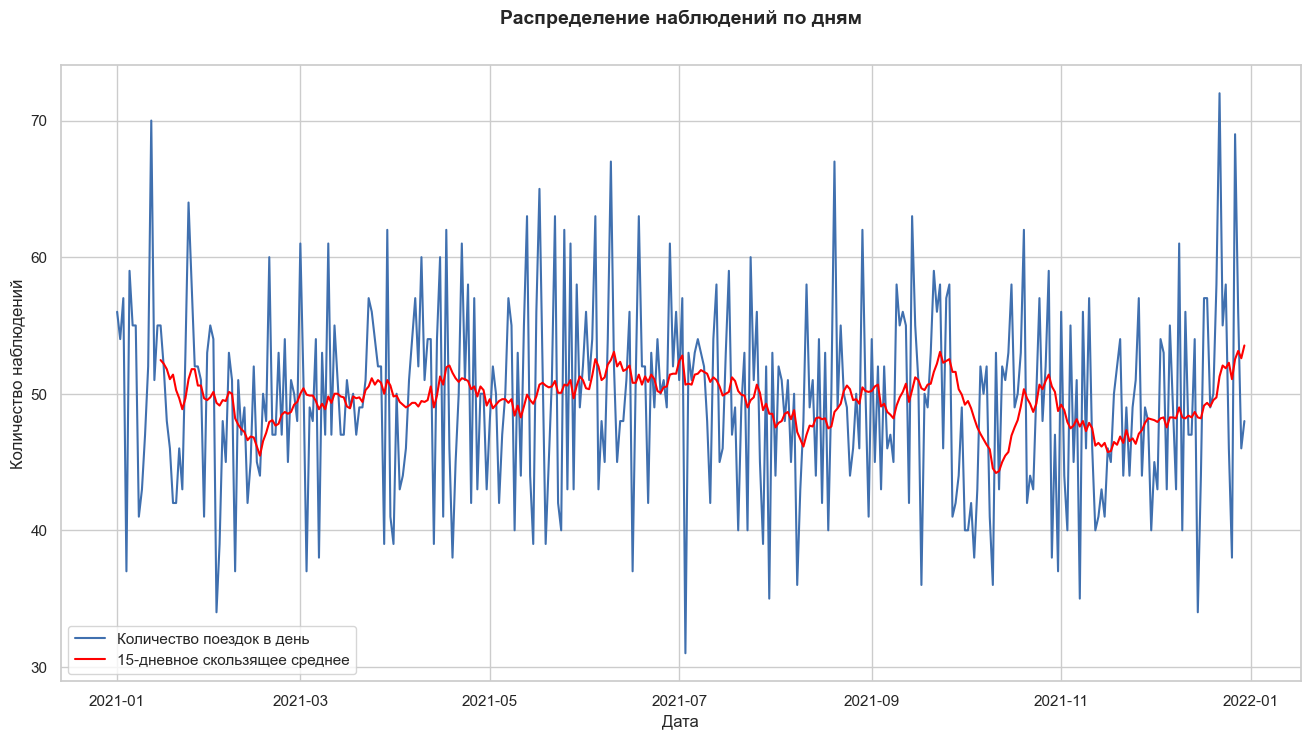

In [15]:
# Создание фигуры и осей для графика с заданным размером
fig, ax = plt.subplots(figsize=(16, 8))

# Группировка данных по дате и подсчет количества пользователей (поездок) в каждый день
time_series = rides.groupby('date').user_id.count()

# Построение линейного графика количества поездок в день
sns.lineplot(x=time_series.index, y=time_series, ax=ax, color=COLORS['base_color'])

# Вычисление 15-дневного скользящего среднего количества поездок в день
mean10 = time_series.rolling(15).mean()

# Построение линейного графика 15-дневного скользящего среднего
sns.lineplot(x=mean10.index, y=mean10, ax=ax, color='red')

# Добавление заголовка с заданными параметрами шрифта
plt.title('Распределение наблюдений по дням', 
          fontsize=14, fontweight='bold', pad=30)

# Добавление названия осей
plt.xlabel('Дата')
plt.ylabel('Количество наблюдений')

# Добавление легенды с описанием линий
plt.legend(['Количество поездок в день', '15-дневное скользящее среднее'])

# Отображение графика
plt.show()

В нашей выборке наблюдения с 1 января 2021 года по 31 декабря 2021 года. Зимой самокатами пользуются намного реже чем летом, а в нашей выборке такой тенденции не наблюдается. Надо проверить как формировались данные.

##### Посмотрим частоту встречаемости городов

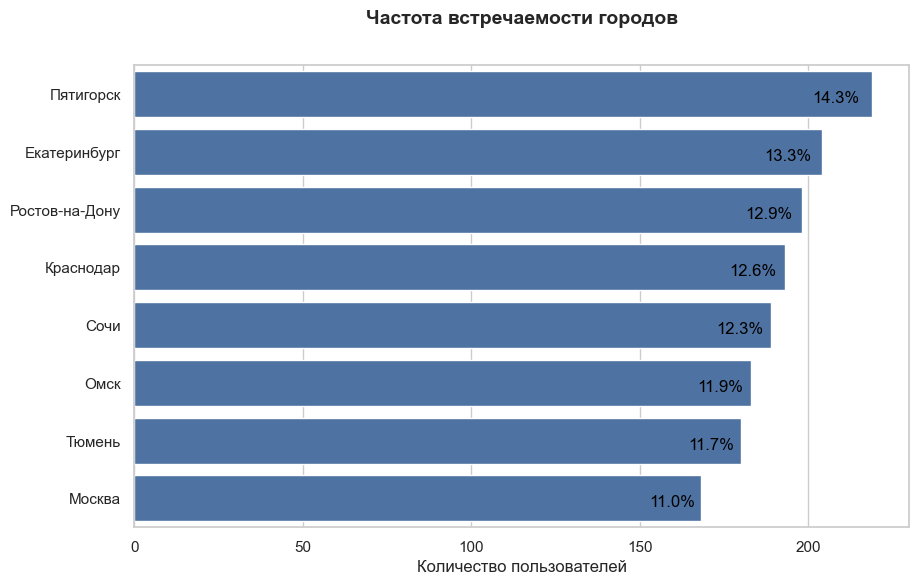

In [16]:
# Создаем фигуру и оси для графика с заданным размером
fig, ax = plt.subplots(figsize=(10, 6))

# Получаем данные о количестве пользователей в каждом городе
data = users.city.value_counts()

# Создаем горизонтальную столбчатую диаграмму с использованием Seaborn
sns.barplot(x=data, y=data.index, color=COLORS['base_color'], ax=ax)

# добавим подписи долей в процентах
for i, val in enumerate(data.values / data.sum()):
    ax.text(data.values[i]*0.95, i+0.2, f"{round(val*100, 1)}%", 
                         horizontalalignment='center', 
                         verticalalignment='bottom', 
                         fontdict={'fontweight':500, 'size': 12, 'color': 'black'})

# Устанавливаем название для оси X
plt.xlabel('Количество пользователей')

# Устанавливаем заголовок графика с заданным шрифтом и отступом
plt.title('Частота встречаемости городов', 
          fontsize=14, fontweight='bold', pad=30)

# Отображаем график
plt.show()


У нас больше всего пользователей в Пятигорске и меньше всего в Москве.
Xотелось бы верить, что наша выборка стратифицирована по городам, иначе она не будет репрезентативна. Если бы у меня была возможность я бы ознакомился с тем, как формировалась выборка.

##### Соотношение пользователей с подпиской и без подписки

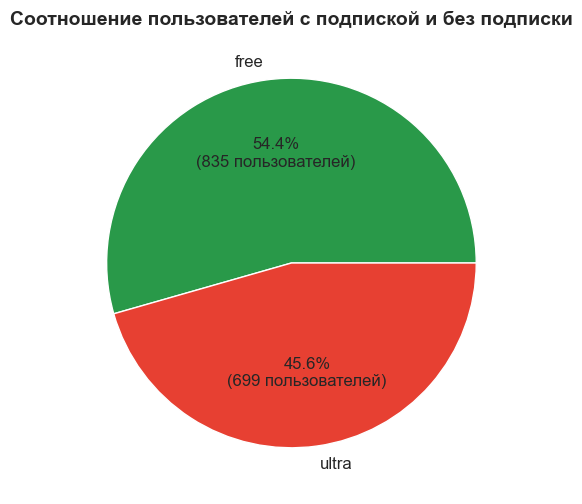

Общее количество пользователей - 1534


In [17]:
# Получаем данные о количестве пользователей с различными типами подписок
data = users.subscription_type.value_counts().reset_index()

# Сопоставляем каждому типу подписки его цвет из словаря colors
data['colors'] = data['index'].map(COLORS['subscription'])

# Функция для отображения процентного соотношения 
# и абсолютного количества пользователей на круговой диаграмме
def func(pct, allvals):
    value = allvals.subscription_type.sum() * pct / 100
    return f"{pct:.1f}%\n({value:.0f} пользователей)"
    
# Создаем круговую диаграмму с заданным размером
plt.figure(figsize=(10, 6)) 
plt.pie(
    data['subscription_type'],  # данные для диаграммы
    labels=data['index'],  # метки с типами подписок
    colors=data['colors'],  # цвета сегментов
    # формат отображения процентов и количества пользователей
    autopct=lambda pct: func(pct, data),  
    textprops={'fontsize': 12},  # свойства текста меток
)
# Устанавливаем заголовок диаграммы
plt.title(
    'Соотношение пользователей с подпиской и без подписки', 
    fontsize=14,
    fontweight="bold"
)
# Отображаем диаграмму
plt.show()

# Выводим общее количество пользователей
print(f'Общее количество пользователей - {users.shape[0]}')

Как и в предыдущем случае хотелось чтобы в нашей генеральной совокупности был такой же баланс пользователей с подпиской и без.

##### Возраст пользователей

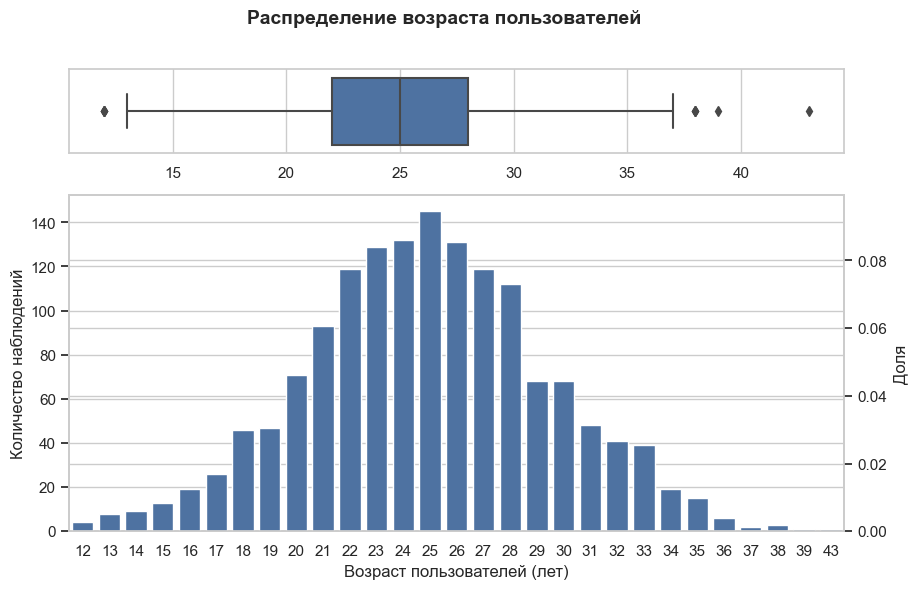

In [18]:
# Создаем фигуру с двумя горизонтальными подграфиками разной высоты
fig, axes = plt.subplots(
    # 2 строки, 1 столбец, оси X не совмещены
    nrows=2, ncols=1, sharex=False, 
    # Отношение высоты верхнего и нижнего графика
    gridspec_kw={"height_ratios": (.2, .8)},  
    figsize=(10, 6)  # Размер фигуры в дюймах (ширина, высота)
)
ax2 = axes[1].twinx()

# Верхний график: boxplot возраста пользователей
sns.boxplot(data=users, 
            x='age', 
            ax=axes[0], 
            orient='h', 
            color=COLORS['base_color']
           )
# Нижний график: столбчатая диаграмма (countplot) возраста пользователей
sns.countplot(data=users, x='age', color=COLORS['base_color'], ax=axes[1])

# Добавляем на ось Y справа иформацию о доле
data = users['age'].value_counts()
data = data.sort_index() / data.sum()
data.name = 'Доля'
sns.barplot(x=data.index, y=data, ax=ax2, color=COLORS['base_color'])

# Убираем название оси X у верхнего графика
axes[0].set_xlabel('')

# Устанавливаем названия для осей Y и X нижнего графика
axes[1].set_ylabel('Количество наблюдений', fontsize=12)
axes[1].set_xlabel('Возраст пользователей (лет)', fontsize=12)

# Устанавливаем общий заголовок для фигуры
fig.suptitle('Распределение возраста пользователей', 
            fontsize=14,
            fontweight="bold",
)
# Отображаем графики
plt.show()

Медиана и мода возраста нашего пользователя - 25 лет. Распределение возраста нашего пользователя похоже на нормальное, это значит что с большей вероятностью мы будем встречать значения близкие к 25. Максимальный возраст в наших наблюдениях 43 года, минимальный 12 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

In [19]:
def plot_distribution(
    df: pd.DataFrame, column: str,* , title: str, xlabel: str
    ) -> None:
    """
    Строит визуализацию распределения значений в указанном столбце DataFrame.

    Функция создает два горизонтальных подграфика: boxplot и гистограмму,
    для отображения распределения значений в столбце. Это позволяет
    оценить общее распределение, наличие выбросов и частоту значений.

    Parameters:
    df (pd.DataFrame): DataFrame, содержащий данные для визуализации.
    column (str): Название столбца в DataFrame, для которого будет построено распределение.
    title (str): Заголовок для графика.
    xlabel (str): Название оси X, которое будет отображено на графике.

    Returns: None
    """
    
    # Создаем фигуру с двумя горизонтальными подграфиками разной высоты
    fig, axes = plt.subplots(
        # 2 строки, 1 столбец, оси X не совмещены
        nrows=2, ncols=1, sharex=False, 
        # Отношение высоты верхнего и нижнего графика
        gridspec_kw={"height_ratios": (.2, .8)},  
        figsize=(10, 6)  # Размер фигуры в дюймах (ширина, высота)
    )

    # Верхний график: boxplot
    sns.boxplot(data=df, 
                x=column,
                ax=axes[0], 
                orient='h', 
                color=COLORS['base_color'],
               )
        
    # Нижний график: гистограмма (histplot)
    sns.histplot(data=df, x=column, 
                 color=COLORS['base_color'], 
                 ax=axes[1], alpha=1)

    # Убираем название оси X у верхнего графика
    axes[0].set_xlabel('')

    # Устанавливаем названия для осей Y и X нижнего графика
    axes[1].set_ylabel('Частота', fontsize=12)
    axes[1].set_xlabel(xlabel, fontsize=12)

    # Устанавливаем общий заголовок для фигуры
    fig.suptitle(f'Распределение {title}', 
                fontsize=14,
                fontweight="bold",
    )
    # Отображаем графики
    plt.show()

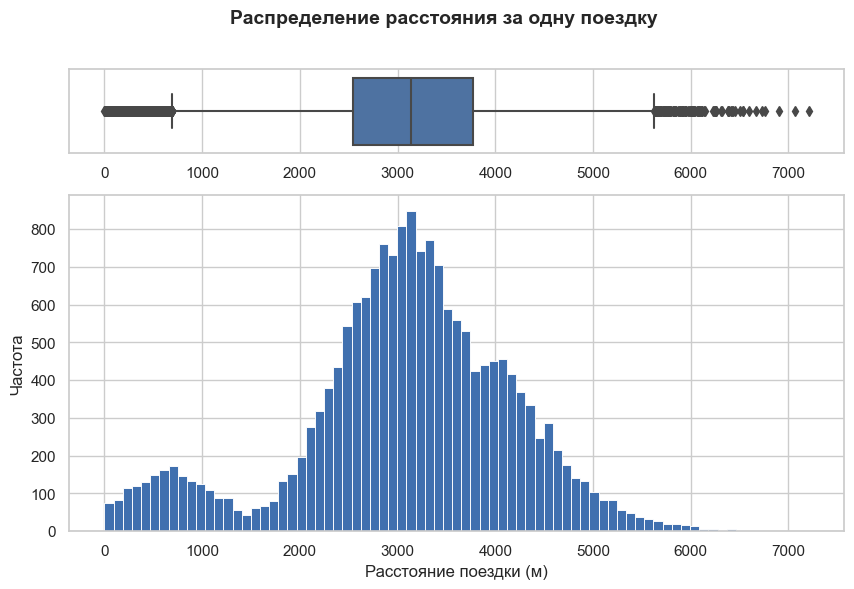

In [20]:
plot_distribution(rides, 'distance', 
                  title='расстояния за одну поездку', 
                  xlabel='Расстояние поездки (м)')

Мода и медиана поездки немногим больше 3000 м. Распределение расстояния поездки похоже на нормальное, но у нас есть небольшой пик меньше 1000 м.

##### Продолжительность поездок

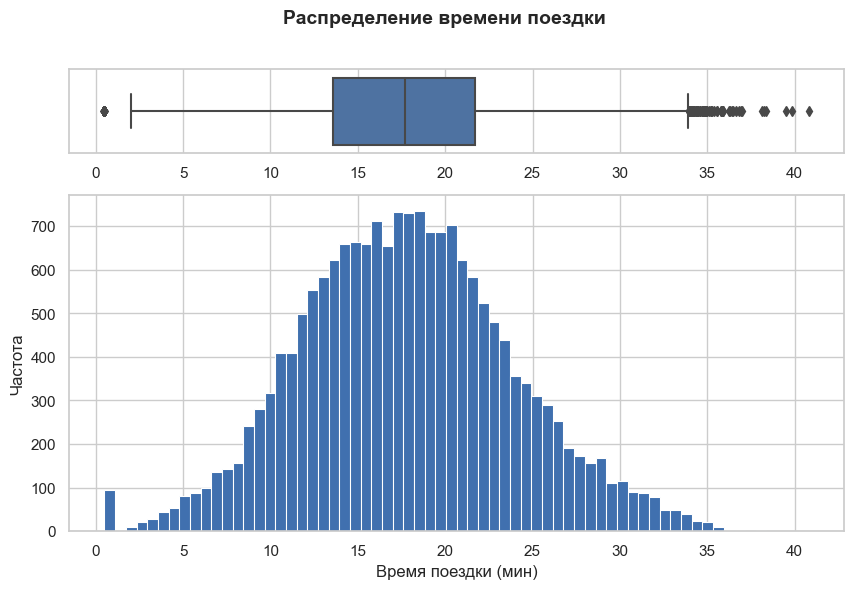

In [21]:
plot_distribution(rides, 'duration', 
                  title='времени поездки', 
                  xlabel='Время поездки (мин)')

Мода и медиана продолжительности поездки около 17.5 минут. Распределение поездки тоже похоже на нормальное, но мы имеем всплеск поездок около одной минуты.

##### Вывод по исследовательскому анализу

- Зимой самокатами пользуются намного реже чем летом, а в нашей выборке такой тенденции не наблюдается, также стоит проверить распределение по городам в нашей генеральной совокупности. Есть подозрение на неправильное формирование выборки.

- В нашей выборке 55 % пользователей без подписки и 45 % с подпиской.

- Возрастные показатели пользователей с медианой и модой в 25 лет и распределением, похожим на нормальное, говорят о том, что большинство пользователей находятся в возрастной категории около 25 лет, с максимальным возрастом в 43 года и минимальным в 12 лет.

- Распределение расстояния поездок с модой и медианой чуть больше 3000 метров также кажется нормальным, но с небольшим пиком для коротких поездок менее 1000 метров. Это может указывать на наличие определённой группы пользователей, которые предпочитают очень короткие поездки.

- Продолжительность поездок с модой и медианой около 17.5 минут и распределением, напоминающим нормальное, но с всплеском для очень коротких поездок около одной минуты, может свидетельствовать о наличии специфических условий использования или о технических проблемах.

#### Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм

In [22]:
df = (users
        .merge(rides, how='inner', on='user_id')
        .merge(subcriptions, how='inner', on='subscription_type'))

Создадим два датафрейма:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [23]:
df_nosubscription = df[df.subscription_type == 'free']
df_subscription = df[df.subscription_type == 'ultra']

##### Самокаты зимой

В южных городах, например Сочи и Краснодар аренда самокатов в зимнее время безусловно работает. Но я точно знаю, что в москве аренда самокатов не работает, их просто завалит снегом и снегоуборщик отвезет их в плавильню)).

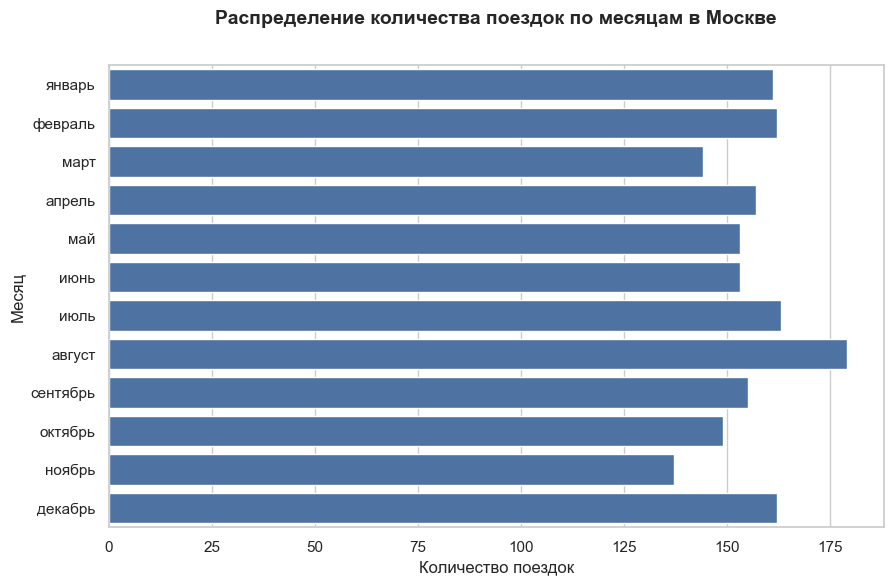

In [24]:
months = {
    1: 'январь',
    2: 'февраль',
    3: 'март',
    4: 'апрель',
    5: 'май',
    6: 'июнь',
    7: 'июль',
    8: 'август',
    9: 'сентябрь',
    10: 'октябрь',
    11: 'ноябрь',
    12: 'декабрь'
}

moscow = df[df.city == 'Москва'].groupby('month_number', as_index=False).user_id.count()
moscow['month'] = moscow.month_number.map(months)

# Создаем фигуру и оси для графика с заданным размером
fig, ax = plt.subplots(figsize=(10, 6))

# Создаем горизонтальную столбчатую диаграмму с использованием Seaborn
sns.barplot(data=moscow, x='user_id', y='month', color=COLORS['base_color'], ax=ax)

# Устанавливаем название для оси X и Y
plt.xlabel('Количество поездок')
plt.ylabel('Месяц')

# Устанавливаем заголовок графика с заданным шрифтом и отступом
plt.title('Распределение количества поездок по месяцам в Москве', 
          fontsize=14, fontweight='bold', pad=30)

# Отображаем график
plt.show()

Поездки в Москве в январе и феврале, это говорит об ошибках при сборе данных.

##### Расстояние и время поездок для пользователей с подпиской и без

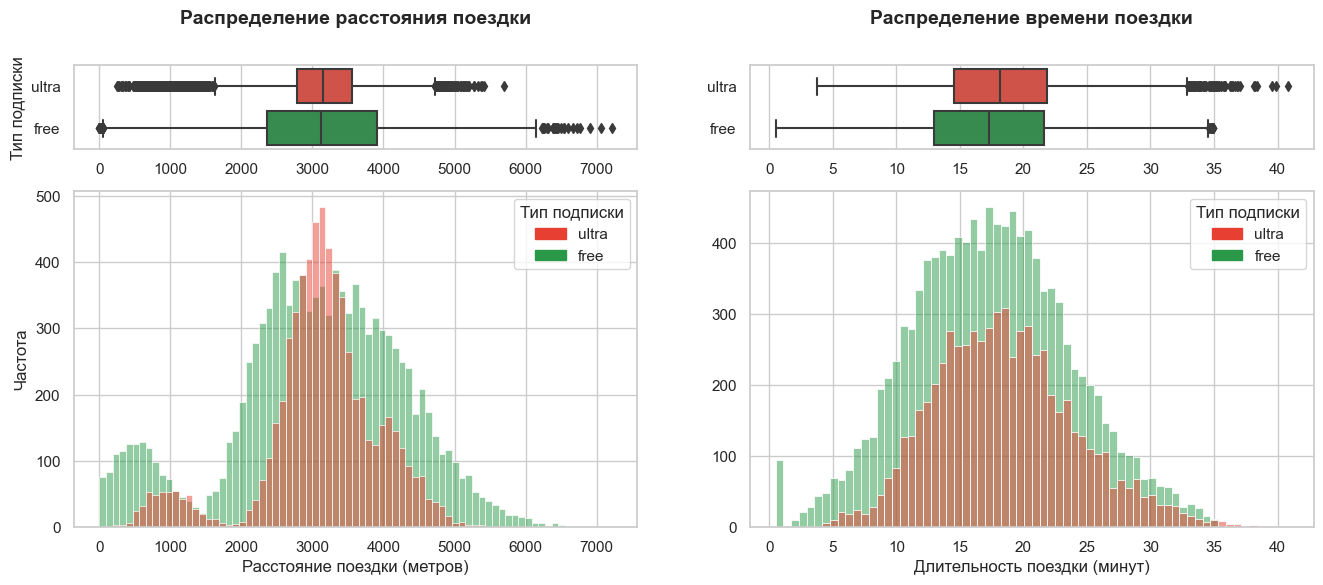

In [25]:
# Создаем фигуру с четырьмя подграфиками разной высоты
fig, axes = plt.subplots(
    # 2 строки, 2 столбца, оси X не совмещены
    nrows=2, ncols=2, sharex=False, 
    # Отношение высоты верхнего и нижнего графика
    gridspec_kw={"height_ratios": (.2, .8)},  
    figsize=(16, 6)  # Размер фигуры в дюймах (ширина, высота)
)

# Верхний левый график: boxplot
sns.boxplot(data=df, 
            x='distance',
            ax=axes[0, 0], 
            orient='h', 
            y='subscription_type',
            palette=COLORS['subscription'],
           )

# Верхний правый график: boxplot
sns.boxplot(data=df, 
            x='duration',
            ax=axes[0, 1], 
            orient='h', 
            y='subscription_type',
            palette=COLORS['subscription'],
           )

# Нижний левый график: гистограмма (histplot)
sns.histplot(data=df, x='distance', 
             color=COLORS['base_color'], 
             ax=axes[1, 0], alpha=0.5, 
             hue='subscription_type', 
             palette=COLORS['subscription'])

# Нижний правый график: гистограмма (histplot)
sns.histplot(data=df, x='duration', 
             color=COLORS['base_color'], 
             ax=axes[1, 1], alpha=0.5, 
             hue='subscription_type', 
             palette=COLORS['subscription'])

# Убираем название оси X у верхнего графика
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')

# Устанавливаем названия для осей Y и X
axes[0, 0].set_ylabel('Тип подписки', fontsize=12)
axes[0, 1].set_ylabel('', fontsize=12)
axes[1, 0].set_ylabel('Частота', fontsize=12)
axes[1, 1].set_ylabel('', fontsize=12)
axes[1, 0].set_xlabel('Расстояние поездки (метров)', fontsize=12)
axes[1, 1].set_xlabel('Длительность поездки (минут)', fontsize=12)

# Устанавливаем общий заголовок для фигуры
axes[0, 0].set_title('Распределение расстояния поездки', fontsize=14, fontweight='bold', pad=30)
axes[0, 1].set_title('Распределение времени поездки', fontsize=14, fontweight='bold', pad=30)

# Установим легенды
ultra_patch = mpatches.Patch(color=COLORS['subscription']['ultra'], label='ultra')
free_patch = mpatches.Patch(color=COLORS['subscription']['free'], label='free')
for i in range(2):
    axes[1, i].legend(title='Тип подписки', handles=[ultra_patch, free_patch])

# Отображаем графики
plt.show()

Расстояние поездки пользователей без подписки имеет больший разброс, чем пользователей с подпиской. Причем количество поездок до 1000 метров, у пользователей без подписки, значительно превышает этот же показатель у пользователей с подпиской. Пользователи без подписки имеют около ста поездок длительостью около минуты, у пользователей с подпиской такие поездки практически отсутствуют, возможно это связано с какими то техническими проблемами. В целом распределения продолжительности похожи, но у пользователей с подпиской продолжительность поездки имеет немного больший разброс.

#### Шаг 5. Подсчёт выручки

In [26]:
# Расчет суммарного расстояния поездок для каждого пользователя в каждом месяце
df['distance_sum'] = (
    df.groupby(['user_id', 'month_number'])
    ['distance'].transform('sum'))

# Расчет суммарной продолжительности поездок 
# для каждого пользователя в каждом месяце
df['duration_sum'] = (
    df.groupby(['user_id', 'month_number'])
    ['duration'].transform('sum'))

# Подсчет количества поездок для каждого пользователя в каждом месяце
df['rides_count'] = (df.groupby(['user_id', 'month_number'])
    ['user_id'].transform('count'))

# Округление продолжительности поездок в большую сторону
df['duration_ceil'] = np.ceil(df['duration'])

# Расчет дохода от каждой поездки
df['revenue'] = (
    df['duration_ceil'] * df['minute_price']
    + df['start_ride_price'])

# Расчет суммарного дохода для каждого пользователя в каждом месяце
df['revenue_month'] = (
    df.groupby(['user_id', 'month_number'])
    ['revenue'].transform('sum') + df['subscription_fee'])

# Создание сводной таблицы с уникальными значениями по пользователям и месяцам
pivot_table = df[['user_id', 'month_number', 
                  'distance_sum', 'duration_sum', 
                  'rides_count', 'revenue_month', 
                  'subscription_type']].drop_duplicates()

In [27]:
pivot_table

,user_id,month_number,distance_sum,duration_sum,rides_count,revenue_month,subscription_type
0,1,1,7027.511294,41.416640,2,451.0,ultra
2,1,4,754.159807,6.232113,1,241.0,ultra
3,1,8,6723.470560,44.776802,2,475.0,ultra
5,1,10,5809.911100,31.578017,2,391.0,ultra
7,1,11,7003.499363,53.397424,3,535.0,ultra
...,...,...,...,...,...,...,...
18058,1534,6,3409.468534,24.812678,2,308.0,free
18060,1534,8,7622.453034,47.205960,2,484.0,free
18062,1534,9,4928.173852,22.560373,1,234.0,free
18063,1534,11,13350.015305,76.342174,4,824.0,free


##### Вывод по объединению данных

- Мы объединили данные и смогли посмотреть различия в распределениях показателей пользователей с подпиской и без.
- Расстояние поездки пользователей без подписки имеет больший разброс, чем пользователей с подпиской. Причем количество поездок до 1000 метров, у пользователей без подписки, значительно превышает этот же показатель у пользователей с подпиской. Пользователи без подписки имеют около ста поездок длительостью около минуты, у пользователей с подпиской такие поездки практически отсутствуют, возможно это связано с какими то техническими проблемами. В целом распределения продолжительности похожи, но у пользователей с подпиской продолжительность поездки имеет немного больший разброс.
- У нас имеются поездки на самокатах в зимнее время например в Москве, хотя сервисы аренды самокатов зимой не работают.
- Мы создали сводную таблицу, где посчитали помесячную выручку каждого пользователя.

#### Проверка гипотез

##### Гипотеза о времени поездок

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.
Проверим гипотезу о том, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

Сформулируем нашу гипотезу на языке математике:



$ \mathsf{H}_0: \mu_1 = \mu_2 $<br>
$ \mathsf{H}_1: \mu_1 > \mu_2 $, где

$ \mu_1 $ - математематическое ожидание времени поездки пользователей с подпиской<br>
$ \mu_2 $ - математематическое ожидание времени поездки пользователей без подписки<br>

Наши выборки независимы, поэтому подойдет двухвыборочный t-test для независимых выборок. Будем использовать параметр `equal_var=False`, так как дисперсии распределений различаются, исходя из графика распределений выше.

In [28]:
print(f'Среднее первой выборки: {df_nosubscription.duration.mean():.2f} минут')
print(f'Среднее второй выборки: {df_subscription.duration.mean():.2f} минут')

# определим уровень стат. значимости
alpha = 0.05

results = st.ttest_ind(
    df_subscription.duration,
    df_nosubscription.duration,
    alternative='greater',
    equal_var=False
)

# посмотрим p-value
print(f'p-value - {results.pvalue}' )

# вывод 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Среднее первой выборки: 17.39 минут
Среднее второй выборки: 18.54 минут
p-value - 5.6757813771289775e-37
Отвергаем нулевую гипотезу


Так как p-value очень мало, мы отвергаем нулевую гипотезу о равенстве средних в пользу альтернативной. И мы можем утверждать, что пользователи с подпиской тратят больше времени пользователей без подписки и это различие статистически значимо.

#####  Гипотеза о расстоянии поездок
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Сформулируем гипотезу:

$ \mathsf{H}_0: \mu >= 3130 $<br>
$ \mathsf{H}_1: \mu < 3130 $, где

$ \mu $ - математическое ожидание расстояния поездки

Проведем одновыборочный t-test

In [29]:
print(f'Среднее выборки: {df[df.subscription_type == "ultra"].distance.mean():.2f} метров')

# верхний предел оптимального расстояния
value = 3130

# определим уровень стат.значимости
alpha = 0.05

results = st.ttest_1samp(
    df[df.subscription_type == "ultra"].distance, value,
    alternative='less'
)

# выведем полученное p-value
print(f'p-value: {results.pvalue}')

# вывод 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Среднее выборки: 3115.45 метров
p-value: 0.08046311521502146
Нет оснований отвергнуть нулевую гипотезу


p-value больше уровня стат.значимости, значит у нас нет оснований отвергнуть нулевую гипотезу.

##### Гипотеза о помесячной выручке

Проверим гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Запишем гипотезу на языке математике:

$ \mathsf{H}_0: \mu_1 = \mu_2 $<br>
$ \mathsf{H}_1: \mu_1 > \mu_2 $, где

$ \mu_1 $ - математическое ожидание помесячной выручки пользователей с подпиской <br>
$ \mu_2 $ - математическое ожидание помесячной выручки пользователей без подписки

Подойдет двухвыборочный t-test для независимых выборок. Будем испоьзовать параметр `equal_var=False`, так как дисперсия времени поездок различается и пользователи с подпиской платят допольнительно за подсписку, поэтому у нас есть основания считать, что дисперсии распределений выручки различаются.

In [30]:
sample1 = pivot_table[pivot_table.subscription_type == 'ultra'].revenue_month
sample2 = pivot_table[pivot_table.subscription_type == 'free'].revenue_month

print(f'Среднее первой выборки: {sample1.mean():.2f} рублей')
print(f'Среднее второй выборки: {sample2.mean():.2f} рублей')

# определим уровень стат. значимости
alpha = 0.05

results = st.ttest_ind(
    sample1,
    sample2,
    alternative='greater',
    equal_var=False
)

# посмотрим p-value
print(f'p-value - {results.pvalue}' )

# вывод 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Среднее первой выборки: 362.79 рублей
Среднее второй выборки: 328.64 рублей
p-value - 8.874140893976874e-40
Отвергаем нулевую гипотезу


У нас p-value меньше уровня стат.значимости, значит мы можем утверждать, что средняя выручка пользователей с подпиской выше, чем без.

Визуализируем распределения выручки в разрезе подписок

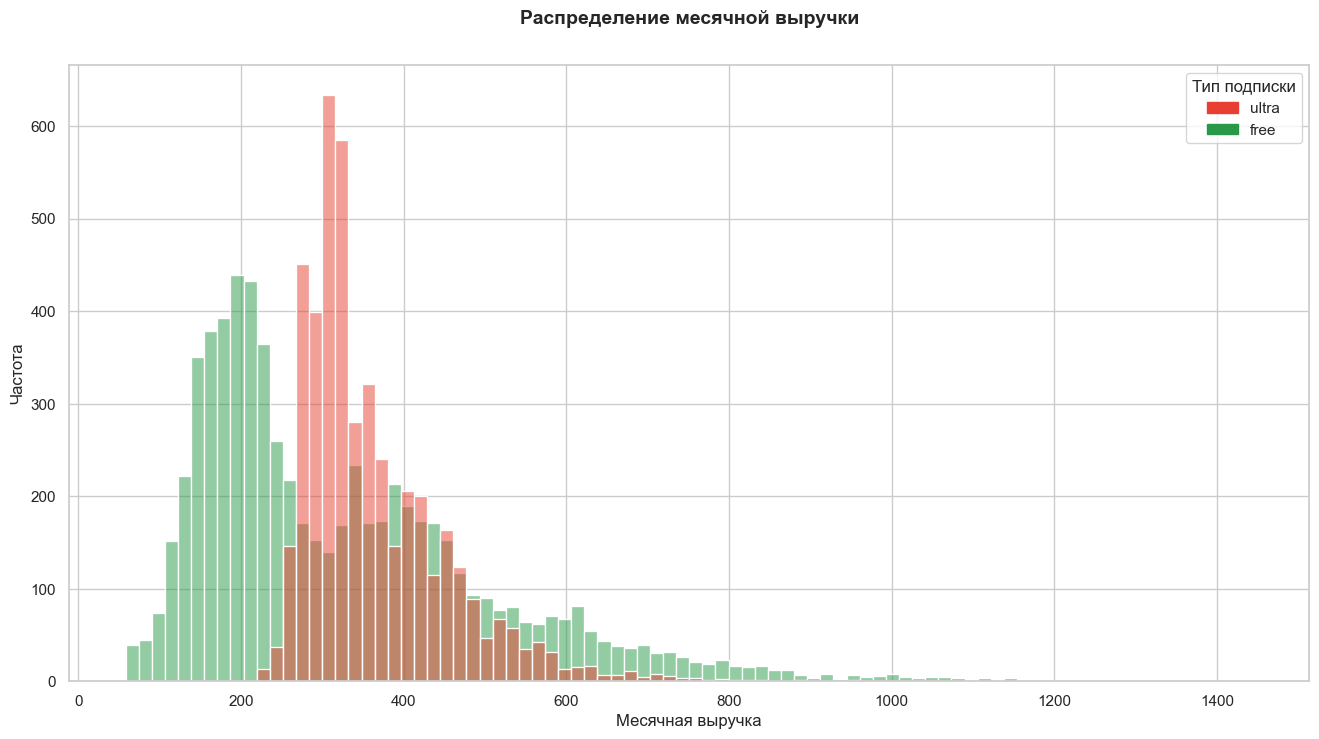

In [31]:
# Создадим фигуру для графика
fig, ax = plt.subplots(figsize=(16, 8))

# нарисуем гистограммы 
sns.histplot(
    pivot_table, 
    x='revenue_month', 
    hue='subscription_type', 
    ax=ax, 
    palette=COLORS['subscription'])
ax.set_xlabel('Месячная выручка')
ax.set_ylabel('Частота')

# Установим легенды
ultra_patch = mpatches.Patch(color=COLORS['subscription']['ultra'], label='ultra')
free_patch = mpatches.Patch(color=COLORS['subscription']['free'], label='free')
for i in range(2):
    ax.legend(title='Тип подписки', handles=[ultra_patch, free_patch])
    
# установим название
ax.set_title(
    'Распределение месячной выручки', 
    pad=30, fontsize=14, fontweight='bold')

# выведем график
plt.show()

Видно что как правило месячная выручка пользователей с подпиской, больше, что подтверждает наш тест. Среди пользователей с месячной выручкой больше 600 рублей, больше пользоватлей без подписки.

Проведем такой же тест по каждому месяцу.

In [32]:
df1 = pivot_table[pivot_table.subscription_type == 'free']
df2 = pivot_table[pivot_table.subscription_type == 'ultra']

for i in range(1, 13):
    sample1 = df1[df1.month_number == i].revenue_month
    sample2 = df2[df2.month_number == i].revenue_month

    # определим уровень стат. значимости
    alpha = 0.05

    results = st.ttest_ind(
        sample1,
        sample2,
        alternative='less',
        equal_var=False
    )

    # вывод 
    if results.pvalue < alpha:
        print(f'{months[i]}: Отвергаем нулевую гипотезу')
    else:
        print(f'{months[i]}: Нет оснований отвергнуть нулевую гипотезу')

январь: Отвергаем нулевую гипотезу
февраль: Отвергаем нулевую гипотезу
март: Отвергаем нулевую гипотезу
апрель: Отвергаем нулевую гипотезу
май: Отвергаем нулевую гипотезу
июнь: Отвергаем нулевую гипотезу
июль: Отвергаем нулевую гипотезу
август: Отвергаем нулевую гипотезу
сентябрь: Отвергаем нулевую гипотезу
октябрь: Отвергаем нулевую гипотезу
ноябрь: Отвергаем нулевую гипотезу
декабрь: Отвергаем нулевую гипотезу


Как видно из теста, для каждого месяца мы с уверенностью можем сказать, что пользователи с подпиской тратят больше.

##### Вывод по проверки гипотез

Проверив гипотезы мы выснили:
- Поездки пользователей с подпиской в среднем продолжительнее поездок пользователей без подписки.
- У нас нет оснований отвергнуть гипотезу о том, что расстояние поездок пользователей с подпиской в среднем более 3130 метров.
- Помесячная выручка пользователей с подпиской выше выручки пользователей без подписки.

#### Распределения

##### Поиск параметра распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Для этого нам нужно, подобрать такой параметр n из  $  B(n, p) $, при котором значение функции распределения вероятности при $k = 99$, меньше $5 \%$.

Попробуем реализовать весь подсчет руками.

In [33]:
def combinations(n: int, k: int) -> Decimal:
    """
    Вычисляет количество сочетаний из n по k.

    Parameters:
    n (int): Общее количество элементов.
    k (int): Количество выбираемых элементов.

    Returns:
    Decimal: Количество возможных сочетаний.
    """
    return Decimal(factorial(n)) / (Decimal(factorial(k)) * Decimal(factorial(n - k)))

def probability_binom(k: int, p: float, n: int) -> float:
    """
    Вычисляет биномиальную вероятность k успехов в n 
    испытаниях с вероятностью успеха p.

    Parameters:
    k (int): Количество успехов.
    p (float): Вероятность успеха в одном испытании.
    n (int): Общее количество испытаний.

    Returns:
    float: Биномиальная вероятность.
    """
    return combinations(n, k) * Decimal(p**k) * Decimal((1 - p)**(n - k))

def cdf(n: int, stop_k: int, p: float) -> float:
    """
    Вычисляет кумулятивную биномиальную вероятность 
    от 0 до stop_k успехов включительно.

    Parameters:
    n (int): Общее количество испытаний.
    stop_k (int): Верхний предел количества успехов 
    для суммирования вероятностей.
    p (float): Вероятность успеха в одном испытании.

    Returns:
    float: Кумулятивная вероятность.
    """
    cum_prob = 0
    for i in range(stop_k + 1):
        cum_prob += probability_binom(i, p, n)
    return cum_prob

In [34]:
%%time
# Перебираем количество промокодов от 1000 до 9999
for i in range(1000, 10000):
    # Если кумулятивная вероятность меньше 5%, 
    # выводим результат и прерываем цикл
    if cdf(i, 99, 0.1) < 0.05:
        print(f'Минимальное количество промокодов - {i}')
        break

Минимальное количество промокодов - 1161
CPU times: total: 3.05 s
Wall time: 3.03 s


При вычислении факториала получаются очень большие целые числа, и при делении происходит переполнение типа, поэтому приходится использовать Decimal, что очень замедляет расчеты.

Теперь реализуем с помощью модуля scipy

In [35]:
%%time
import scipy.stats as st

# Цикл перебора количества промокодов от 1000 до 9999
for i in range(1000, 10000):
    # Вычисление кумулятивной биномиальной функции распределения (CDF)
    # для i промокодов с вероятностью успеха 0.1 для 99 использований
    if st.binom(i, 0.1).cdf(99) < 0.05:
        # Если вероятность того, что будет использовано менее 100 промокодов, меньше 5%,
        # выводим сообщение с минимально необходимым количеством промокодов
        print(f'Минимальное количество промокодов - {i}')
        # Прерываем цикл, так как нашли минимальное количество промокодов,
        # удовлетворяющее условию
        break

Минимальное количество промокодов - 1161
CPU times: total: 62.5 ms
Wall time: 54 ms


Грамотная реализация решает, быстрее в 200 раз, но результат такой же.

Проверим выходит ли $  \mu \pm 3\sigma  $ за диапазон возможных значений $k$, при $n = 1000$.

In [36]:
n = 1000
p = 0.1
mu = n * p
sigma = (n * p * (1 - p)) ** 0.5

# вычислим дианазон 3 сигм
mu - 3*sigma, mu + 3*sigma

(71.53950105848459, 128.46049894151543)

Так как, диапазон трех сигм не включает значений меньше нуля и больше n, мы можем использовать апроксимацию нормальной функцией распределения. При большем n, апроксимация будет только ближе. Попробуем сделать те же вычисления с помощью апроксимации нормальным распределением.

In [37]:
%%time
# Задаем вероятность использования одного промокода
p = 0.1

# Цикл перебора количества промокодов от 1000 до 9999
for i in range(1000, 10000):
    # Вычисляем математическое ожидание (среднее) распределения
    mu = i * p
    # Вычисляем стандартное отклонение распределения
    sigma = (i * p * (1 - p))**0.5
    # Используем нормальное приближение биномиального распределения
    # для вычисления вероятности того, что будет использовано менее 100 промокодов
    if st.norm(mu, sigma).cdf(99) < 0.05:
        # Если вероятность меньше 5%, выводим минимальное количество промокодов
        print(f'Минимальное количество промокодов - {i}')
        # Прерываем цикл после нахождения минимального количества
        break

Минимальное количество промокодов - 1158
CPU times: total: 62.5 ms
Wall time: 56 ms


Результат немного отличается от точного вычисления, но приближение неплохое.

In [38]:
# Параметры биномиального распределения
n = 1000  # количество испытаний
p = 0.1  # вероятность успеха

# Параметры нормального распределения для аппроксимации
mu = n * p
sigma = (n * p * (1 - p))**0.5
max_error = 0
sum_error = 0
for k in range(n + 1):
    
    # Точная вероятность для биномиального распределения
    binom_prob = st.binom(n, p).pmf(k)

    # Аппроксимирующая вероятность для нормального распределения
    norm_prob = st.norm(mu, sigma).pdf(k)

    # Оценка ошибки аппроксимации
    error = abs(binom_prob - norm_prob)
    sum_error += error
    if error > max_error:
        max_error = error
        
# вывод результатов
print(f'Суммарная ошибка аппроксимации: {sum_error:.2%}')
print(f'Максимальная ошибка аппроксимации: {max_error:.2%}')

Суммарная ошибка аппроксимации: 2.13%
Максимальная ошибка аппроксимации: 0.08%


Как видим ошибка небольшая, но если мы будем считать кумулятивную функцию распределения, то ошибка может достигать 2%, а это уже не мало.

Визуализируем функцию распределения

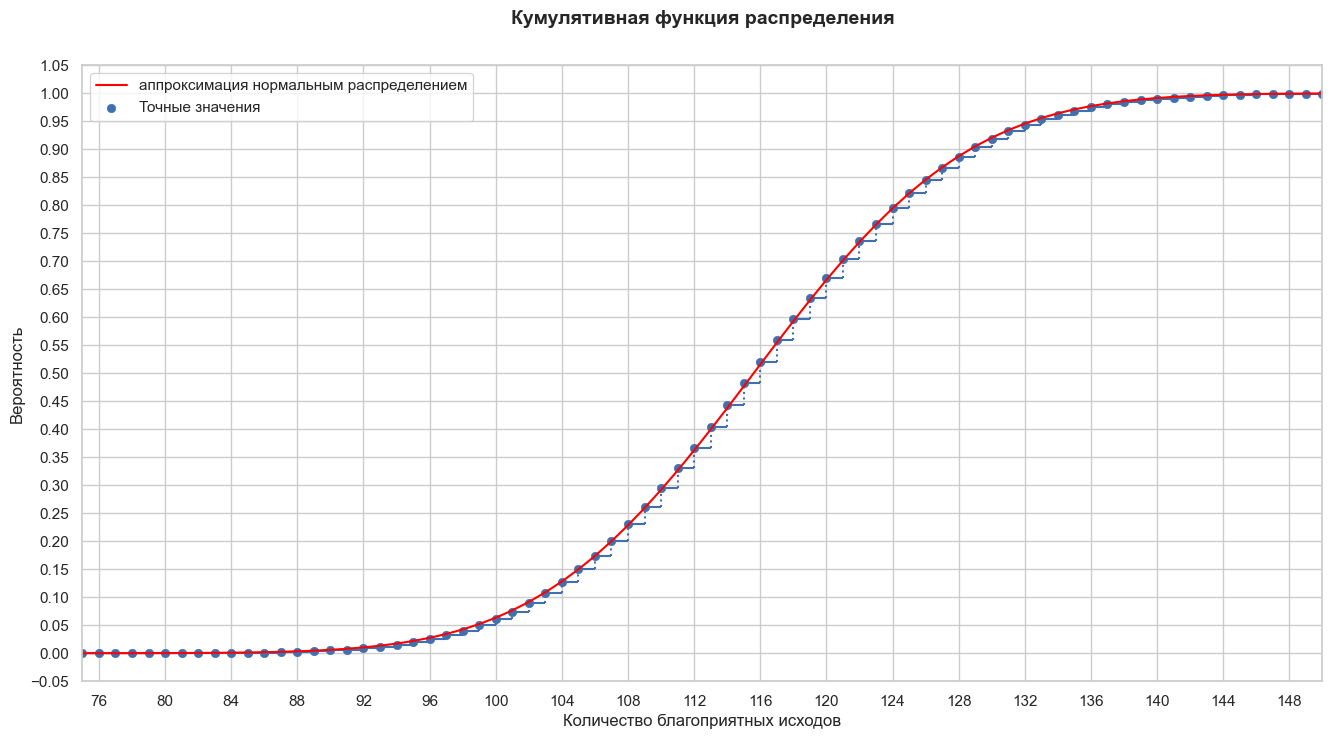

In [46]:
# Создание фигуры и осей для графика с заданным размером
fig, ax = plt.subplots(figsize=(16, 8))

# Создание DataFrame с последовательностью чисел от 0 до 1161
data = pd.DataFrame({'k': range(0, 1162)})

# Применение функции probability_binom к каждому значению в столбце 'k'
# для вычисления биномиальной вероятности
data['p'] = data['k'].apply(lambda k: st.binom(1161, 0.1).pmf(k))

# Апроксимируем с помощью нормального распределения
mu = 1161 * 0.1
sigma = (1161 * 0.1 * 0.9)**0.5
data['p_normal'] = data['k'].apply(lambda k: st.norm(mu, sigma).pdf(k))

# Вычисление кумулятивной суммы вероятностей 
# для получения функции распределения
data['cdf'] = data['p'].cumsum()
data['cdf_normal'] = data['p_normal'].cumsum()

# наносим значения кумулятивной функции
plt.scatter(data['k'], data['cdf'], 
                alpha=1, linewidths=0.5,
                color=COLORS['base_color'])

# наносим горизонтальные линии
plt.hlines(data['cdf'][:-1], data['k'][:-1], data['k'][1:], 
               color=COLORS['base_color'], linestyle='-')

# наносим вертикальные точечки
plt.vlines(data['k'][1:], data['cdf'][:-1], data['cdf'][1:], 
               color=COLORS['base_color'], linestyle=':')

# Наносим аппроксимацию нормальным распределением
sns.lineplot(x=data.k, y=data.cdf_normal, color='red')

# Установка пределов для оси X
plt.xlim(75, 150)

# Установка заголовка графика с заданными параметрами шрифта
plt.title('Кумулятивная функция распределения', fontsize=14, fontweight='bold', pad=30)

# установка названия оси Y и X
plt.ylabel('Вероятность')
plt.xlabel('Количество благоприятных исходов')

# установим количество тиков на осях
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.yaxis.set_major_locator(plt.MaxNLocator(22))

# Добавим легенду
plt.legend(['аппроксимация нормальным распределением', 'Точные значения'])

# Отображение графика
plt.show()

Видно как хорошо биномиальное распределение приближается нормальным

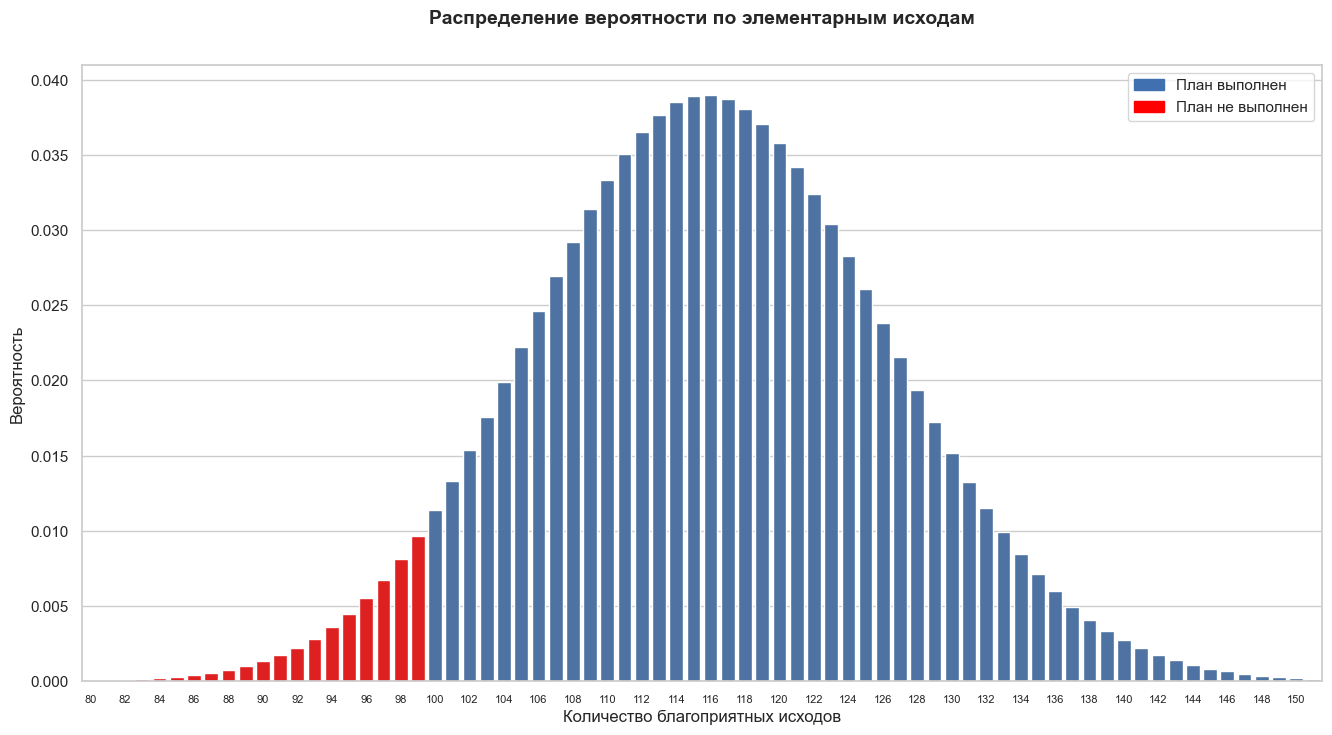

In [41]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(
    x=data['k'][80:152], 
    y=data['p'][80:152],
    ax=ax,
    palette=[
        COLORS['base_color'] if cdf > 0.05 else 'red' 
        for cdf in data['cdf']][80:152]
)

# Уменьшаем размер шрифта тиков на оси X
plt.xticks(fontsize=8)
plt.title('Распределение вероятности по элементарным исходам', fontsize=14, fontweight='bold', pad=30)
plt.ylabel('Вероятность')
plt.xlabel('Количество благоприятных исходов')
# устанавливаем количество тиков
ax.xaxis.set_major_locator(plt.MaxNLocator(40))

# Установим легенды
pos_patch = mpatches.Patch(color=COLORS['base_color'], label='План выполнен')
neg_patch = mpatches.Patch(color='red', label='План не выполнен')
for i in range(2):
    ax.legend(title='', handles=[pos_patch, neg_patch])

plt.show()

Элементарные исходы которые мы не хотели бы видеть отмечены красным цветом, при суммировании их вероятностей, мы молучим немногим менее 5 %. Давайте посмотрим на это увеличив график.

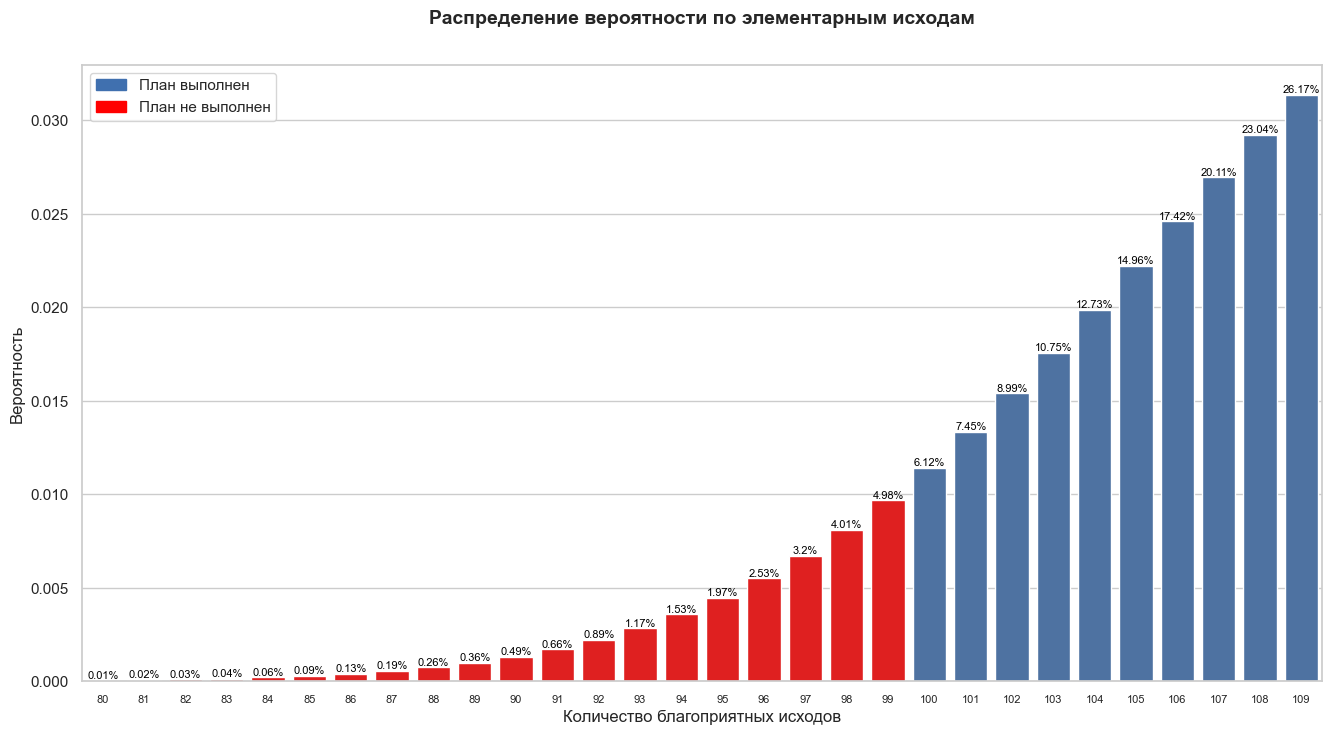

In [42]:
start = 80
stop = 110
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(
    x=data['k'][start:stop], 
    y=data['p'][start:stop],
    ax=ax,
    palette=[
        COLORS['base_color'] if cdf > 0.05 else 'red' 
        for cdf in data['cdf']][start:stop]
)

# добавим подписи долей в процентах
for i, val in enumerate(range(start, stop)):
    ax.text(i, data['p'][val], f"{round(data['cdf'][val]*100, 2)}%", 
                         horizontalalignment='center', 
                         verticalalignment='bottom', 
                         fontdict={'fontweight':500, 'size': 8, 'color': 'black'})

# Уменьшаем размер шрифта тиков на оси X
plt.xticks(fontsize=8)
plt.title('Распределение вероятности по элементарным исходам', fontsize=14, fontweight='bold', pad=30)
plt.ylabel('Вероятность')
plt.xlabel('Количество благоприятных исходов')

# Установим легенды
pos_patch = mpatches.Patch(color=COLORS['base_color'], label='План выполнен')
neg_patch = mpatches.Patch(color='red', label='План не выполнен')
for i in range(2):
    ax.legend(title='', handles=[pos_patch, neg_patch])

plt.show()

Над столбцами изображена веротность с накоплением и мы видим с какой вероятностью мы можем получить такое или более низкое количество повторных подписок.

##### Гипотеза о push-уведомлениях

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Проверим подходит ли нормальное распределение для аппроксимации

In [43]:
n = 1_000_000
p = 0.4
mu = n * p
sigma = (n * p * (1 - p)) ** 0.5

# вычислим дианазон 3 сигм
mu - 3*sigma, mu + 3*sigma

(398530.3061543301, 401469.6938456699)

Так как данный интервал не выходит за пределы 0 и 1 млн. мы можем использовать линейную аппроксимацию.

Построим график и вычислим вероятность того, что из 1 млн. push-уведомлений пользователи откроют 399.5 тыс.

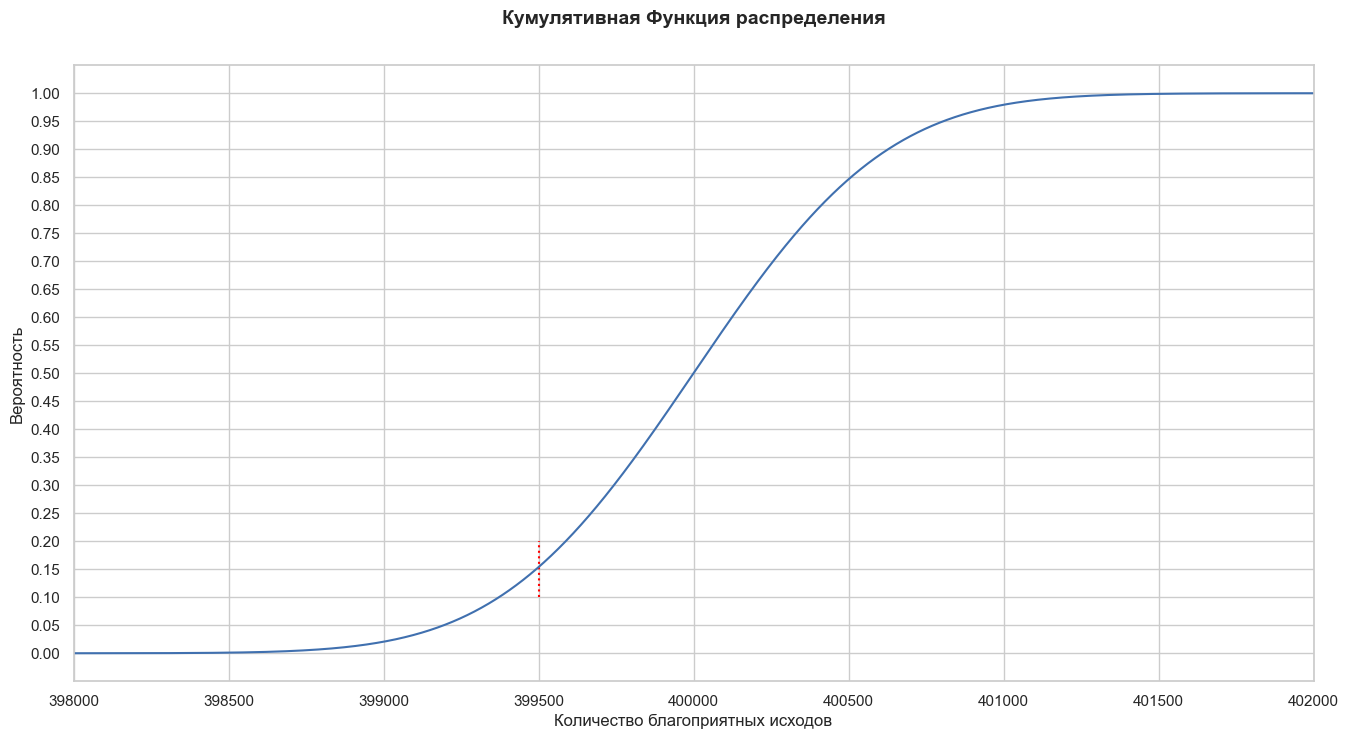

In [44]:
# Создание DataFrame с диапазоном значений 'k'
push = pd.DataFrame({'k': range(398_000, 402_000)})

# Применение функции нормального распределения для вычисления кумулятивной функции распределения (CDF)
push['cdf'] = push['k'].apply(lambda k: st.norm(mu, sigma).cdf(k))

# Применение функции нормального распределения для вычисления плотности вероятности (PDF)
push['p'] = push['k'].apply(lambda k: st.norm(mu, sigma).pdf(k))

# Создание фигуры и осей для графика с заданным размером
fig, ax = plt.subplots(figsize=(16, 8))

# Построение графика кумулятивной функции распределения
sns.lineplot(data=push, x='k', y='cdf', color=COLORS['base_color'])

# добавим маркер интересующего нас события
plt.vlines(399500, 0.1, 0.2, color='red', linestyle=':')

# Установка заголовка, названий осей и форматирование оси Y
plt.title('Кумулятивная Функция распределения', fontsize=14, fontweight='bold', pad=30)
plt.xlabel('Количество благоприятных исходов')
plt.ylabel('Вероятность')
ax.yaxis.set_major_locator(plt.MaxNLocator(22))

# Установка пределов отображения по оси X
plt.xlim(398_000, 402_000)

# Отображение графика
plt.show()

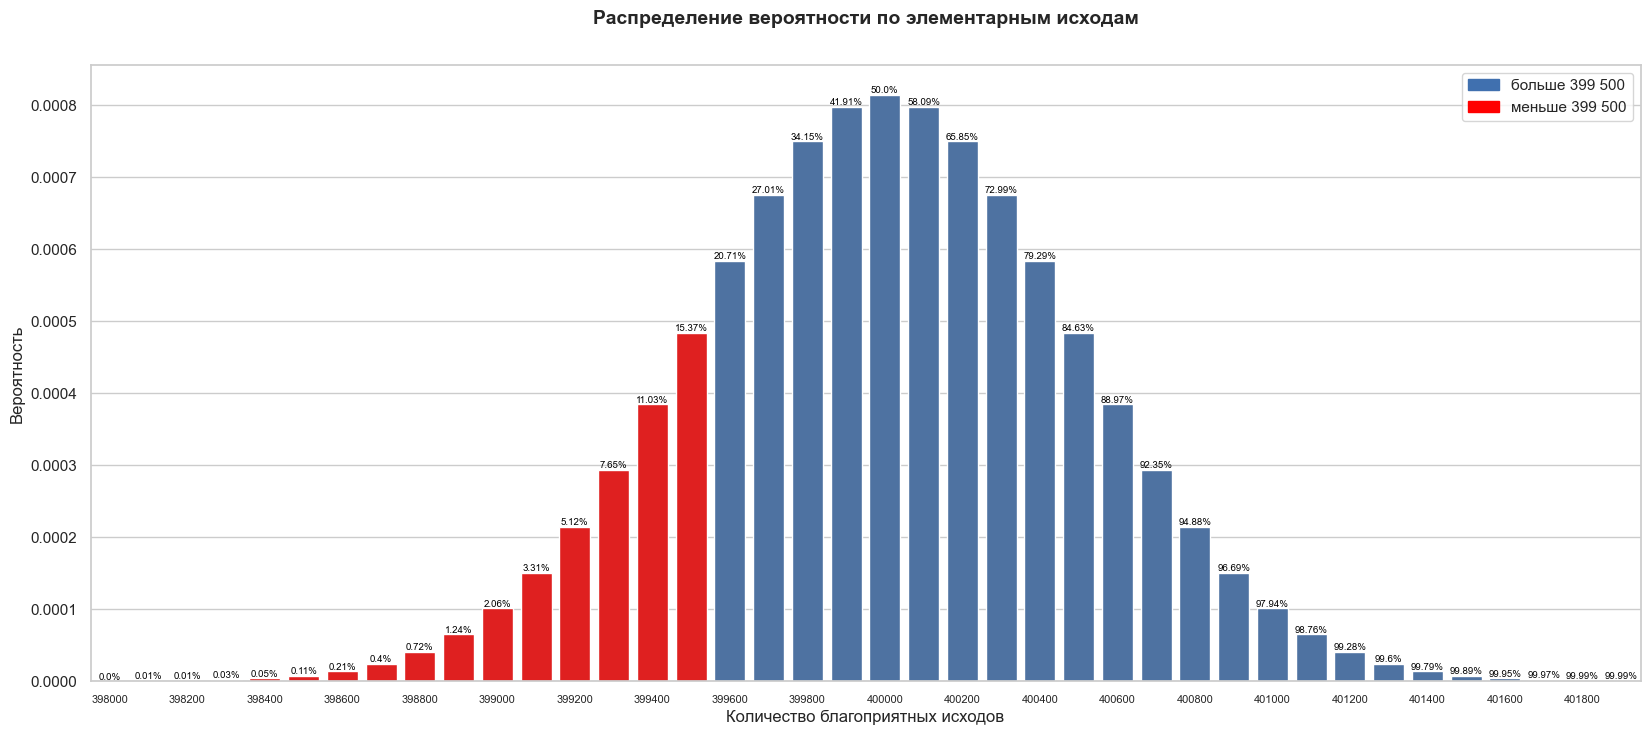

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей - 15.37%


In [45]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x=push['k'][::100], 
    y=push['p'][::100],
    ax=ax,
    palette=[
        COLORS['base_color'] if k > 399_500 else 'red' 
        for k in push['k']][::100]
)

for i, val in push['k'][::100].items():
    ax.text(i//100, push['p'][i], f"{round(push['cdf'][i]*100, 2)}%", 
                         horizontalalignment='center', 
                         verticalalignment='bottom', 
                         fontdict={'fontweight':500, 'size': 7, 'color': 'black'})

# Уменьшаем размер шрифта тиков на оси X
plt.xticks(fontsize=8)
plt.title('Распределение вероятности по элементарным исходам', fontsize=14, fontweight='bold', pad=30)
plt.ylabel('Вероятность')
plt.xlabel('Количество благоприятных исходов')
# устанавливаем количество тиков
ax.xaxis.set_major_locator(plt.MaxNLocator(20))

# Установим легенды
pos_patch = mpatches.Patch(color=COLORS['base_color'], label='больше 399 500')
neg_patch = mpatches.Patch(color='red', label='меньше 399 500')
for i in range(2):
    ax.legend(title='', handles=[pos_patch, neg_patch])

plt.show()
print('Вероятность того, что уведомление откроют',
      'не более 399,5 тыс. пользователей -', 
      f'{st.norm(mu, sigma).cdf(399_500):.2%}')

По графику можно также сказать, что при рассылке 1 млн. push-уведомлений вероятность того, что количество просмотренных уведомлений попадет в интервал (399 000, 401 000) больше 95%.

##### Вывод по распределениям

- чтобы получить как минимум 100 пользователей(с вероятностью > 95%), которые продлят подписку, нужно разослать как минимум 1161 промокод.
- Если разослать 1 млн. push-уведомлений вероятность того, что уведомление откроют не более 399,5 тыс. пользователей - 15.37%

#### Общий вывод

- У нас присутствовали полные дубликаты в таблице users, мы их удалили, таких значений было около 2% от общего числа пользователей.

- Зимой самокатами пользуются намного реже чем летом, а в нашей выборке такой тенденции не наблюдается, также стоит проверить распределение по городам в нашей генеральной совокупности. Есть подозрение на неправильное формирование выборки.

- В нашей выборке 55 % пользователей без подписки и 45 % с подпиской.

- Возрастные показатели пользователей с медианой и модой в 25 лет и распределением, похожим на нормальное, говорят о том, что большинство пользователей находятся в возрастной категории около 25 лет, с максимальным возрастом в 43 года и минимальным в 12 лет.

- Распределение расстояния поездок с модой и медианой чуть больше 3000 метров также кажется нормальным, но с небольшим пиком для коротких поездок менее 1000 метров. Это может указывать на наличие определённой группы пользователей, которые предпочитают очень короткие поездки.

- Продолжительность поездок с модой и медианой около 17.5 минут и распределением, напоминающим нормальное, но с всплеском для очень коротких поездок около одной минуты, может свидетельствовать о наличии специфических условий использования или о технических проблемах.

**Гипотезы**

- Поездки пользователей с подпиской в среднем продолжительнее поездок пользователей без подписки.
- У нас нет оснований отвергнуть гипотезу о том, что расстояние поездок пользователей с подпиской в среднем более 3130 метров.
- Помесячная выручка пользователей с подпиской выше выручки пользователей без подписки.
- чтобы получить как минимум 100 пользователей(с вероятностью > 95%), которые продлят подписку, нужно разослать как минимум 1161 промокод.
- Если разослать 1 млн. push-уведомлений вероятность того, что уведомление откроют не более 399,5 тыс. пользователей - 15.37%